# Verify `cosmopower-jax` derivatives against `numdifftools` derivatives

We verify the `jax.jacfwd` Jacobian $dP_{\mathrm{L}}/d\theta$ against the same Jacobian computed through finite-differencing using `numdifftools`.

## Import modules

In [1]:
import sys, platform, os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "font.family": "STIXGeneral",
    "font.sans-serif": "Computer Modern",
    "font.size": 22})

import numpy as np
import numdifftools as nd

import jax.numpy as jnp
import jax
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX as CPJ
jax.config.update('jax_enable_x64', True)

## Define cosmology

We adopt the cosmology in [Planck 2018 results. VI. Cosmological parameters](https://arxiv.org/abs/1807.06209), specifically the `TT,TE,EE+lowE+lensing+BAO` column in their Table 2.

In [26]:
# Relevant parameters for `cosmopower-jax` - LCDM
## P_lin parameters
h = jnp.array([0.6766,])
ombh2 = 0.02242*jnp.ones_like(h)
omch2 = 0.11933*jnp.ones_like(h)
n_s = 0.9665*jnp.ones_like(h)
A_s = 3.047*jnp.ones_like(h) # ln(10^{10}A_s)
## P_nonlin parameters
A_b = 3.13*jnp.ones_like(h)
eta_b = 0.603*jnp.ones_like(h)
logT_AGN = 7.8*jnp.ones_like(h)
# Redshift
z = 0.7*jnp.ones_like(h)

## Define model and emulate $P_\mathrm{L}(k)$ with `cosmopower-jax`.

We define parameter dictionaries for the default and custom models.

In [27]:
default_params_dict = {'omega_b': ombh2, 'omega_cdm':omch2,\
                       'h': h,\
                       'n_s': n_s,'ln10^{10}A_s': A_s,\
                       'z': z,}

custom_params_dict = {'ombh2': ombh2, 'omch2':omch2,\
                      'logA': A_s,'ns': n_s,\
                      'h': h,\
                      'z': z,
                     'A_b': A_b, 'eta_b': eta_b, 'logT_AGN': logT_AGN,} # P_nonlin parameters

Next we define wrappers for `cosmopower.CosmoPowerJAX.precit()`.

In [55]:
def default_pk_wrapper(params,emulator=CPJ(probe='mpk_lin')):
    k=emulator.modes
    pk=emulator.predict(params.T)
    return pk

def custom_pk_wrapper(params,emulator=CPJ(probe='custom_log',filepath='../cosmology/jense2024/jense_2023_camb_lcdm/networks/jense_2023_camb_lcdm_Pk_lin.npz')):
    k=emulator.modes
    pk=emulator.predict(params.T)
    return pk

Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa), or that you are loading a non-standard model from the cosmopower-organization repo.
Falling back to the dictionary, in case this also fails or does not output the right shape make sure you ran the `convert_tf214.py` script, and that a `.npz` file exists among the trained models, and that you ran `pip install .`. Also make sure that you are asking for the right probe between `custom_log` and `custom_pca`.


Now we take derivatives using `jax.jacfwd` and `numdifftools.Jacobian`.

In [67]:
default_cosmo_labels = [r'$\omega_b$',r'$\omega_{cdm}$',r'$h$',r'$n_s$',r'$\ln10^{10}A_s$',r'$z$']
default_cosmo_params=np.array([default_params_dict['omega_b'],default_params_dict['omega_cdm'],\
                                               default_params_dict['h'],\
                                               default_params_dict['n_s'],default_params_dict['ln10^{10}A_s'],\
                                               default_params_dict['z']])
default_emulator=CPJ(probe='mpk_lin')
default_k=default_emulator.modes
default_pklin_jac_jax = default_emulator.derivative(default_params_dict)
print(default_pklin_jac_jax.shape)
default_pklin_jac_num = nd.Jacobian(default_pk_wrapper,step=2e-3)(default_cosmo_params)
print(default_pklin_jac_num.shape)

custom_cosmo_labels = [r'$\omega_b$',r'$\omega_{cdm}$',r'$\ln10^{10}A_s$',r'$n_s$',r'$h$',r'$z$',r'$A_b$',r'$\eta_b$',r'$\ln T_{\mathrm{AGN}}$']
custom_cosmo_params=np.array([custom_params_dict['ombh2'],custom_params_dict['omch2'],\
                                               custom_params_dict['logA'],custom_params_dict['ns'],\
                                               custom_params_dict['h'],\
                                               custom_params_dict['z'],\
                                               custom_params_dict['A_b'],custom_params_dict['eta_b'],custom_params_dict['logT_AGN']])
custom_pklin_jac_jax = jax.jacfwd(custom_pk_wrapper)(custom_cosmo_params)
print(custom_pklin_jac_jax.shape)
custom_pklin_jac_num = nd.Jacobian(custom_pk_wrapper,step=2e-3)(custom_cosmo_params)
print(custom_pklin_jac_num.shape)

(420, 6, 1)
(420, 6)
(1000, 9, 1)
(1000, 9)


### Default model

Text(0.5, 0.98, '$P^{\\mathrm{default}}_{\\mathrm{L}}$')

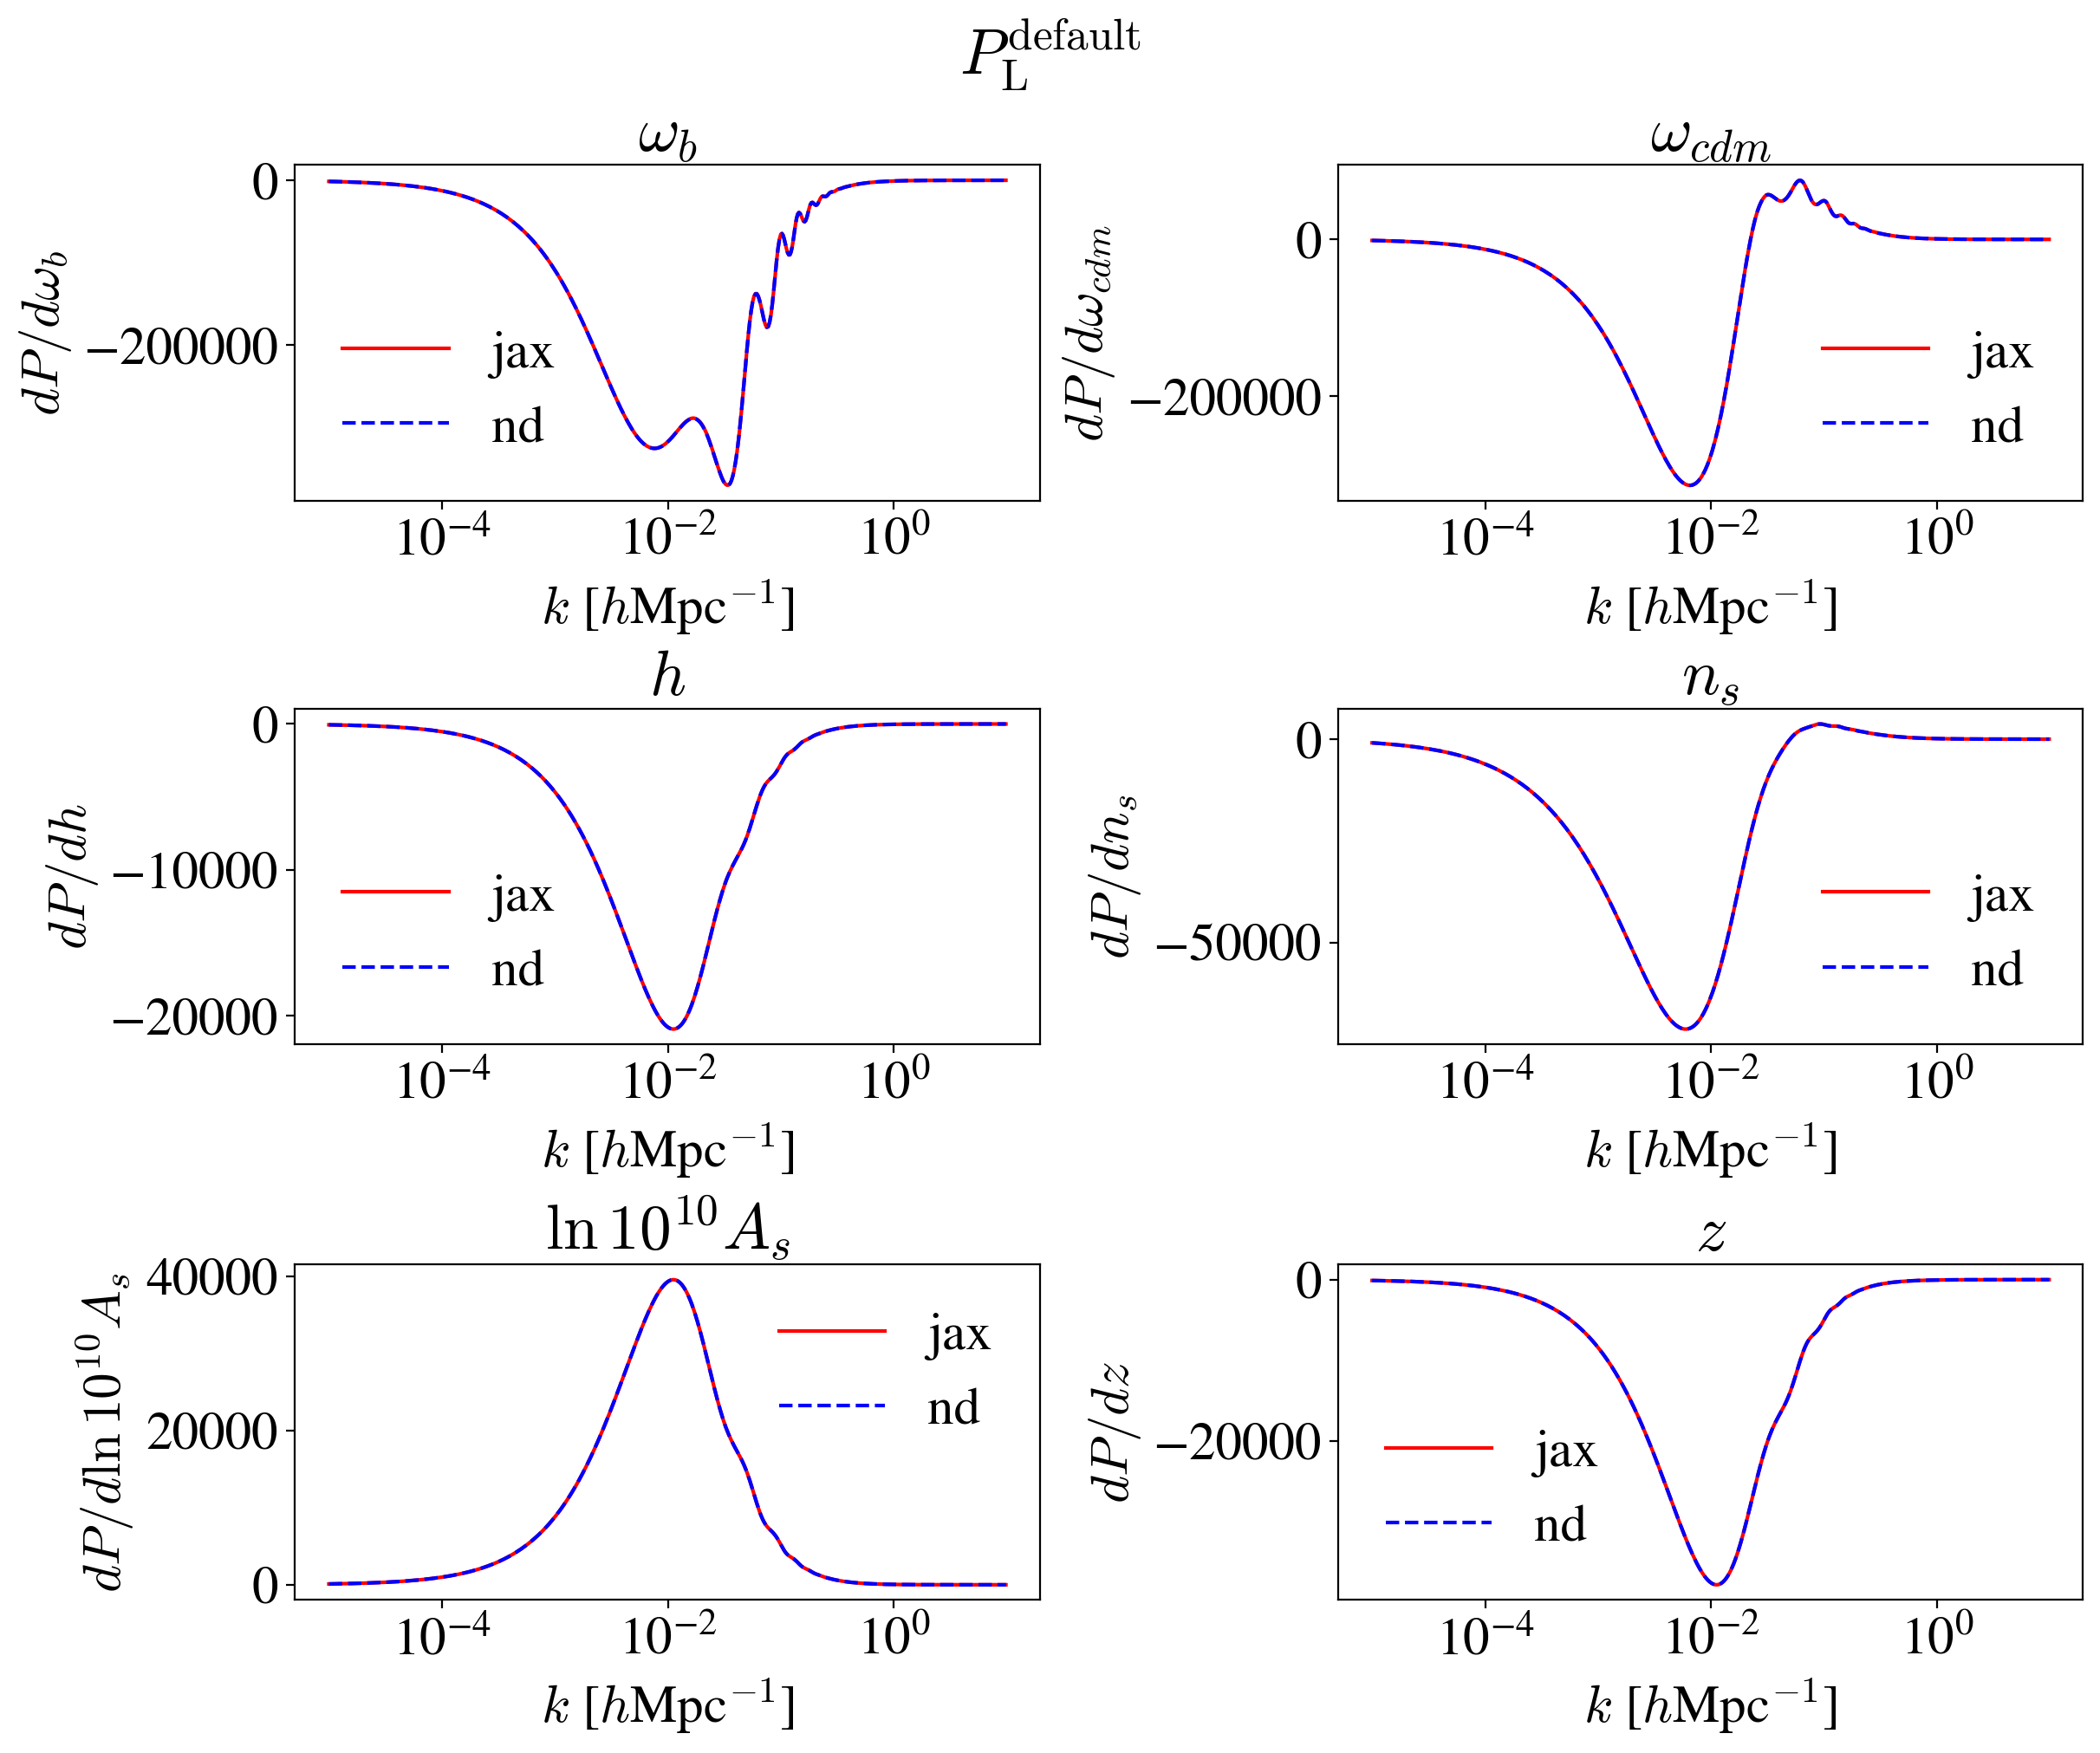

In [68]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10),constrained_layout=True)

for i in range(3):
    for j in range(2):
        idx = 2 * i + j
        ax = axs[i, j]
        if idx >= len(default_cosmo_labels):
            ax.axis('off')  # Hide unused subplot
            continue

        ax.semilogx(default_k, default_pklin_jac_jax[:, idx,0], c='r', label='jax')
        ax.semilogx(default_k, default_pklin_jac_num[:, idx], c='b', ls='--', label='nd')
        ax.set_title(default_cosmo_labels[idx])
        ax.set_xlabel(r'$k$ [$h$Mpc$^{-1}$]')
        ax.set_ylabel(rf'$dP/d${default_cosmo_labels[idx]}')
        ax.legend(frameon=False)
fig.suptitle(r"$P^{\mathrm{default}}_{\mathrm{L}}$")

### Custom model

Text(0.5, 0.98, '$P^{\\mathrm{default}}_{\\mathrm{L}}$')

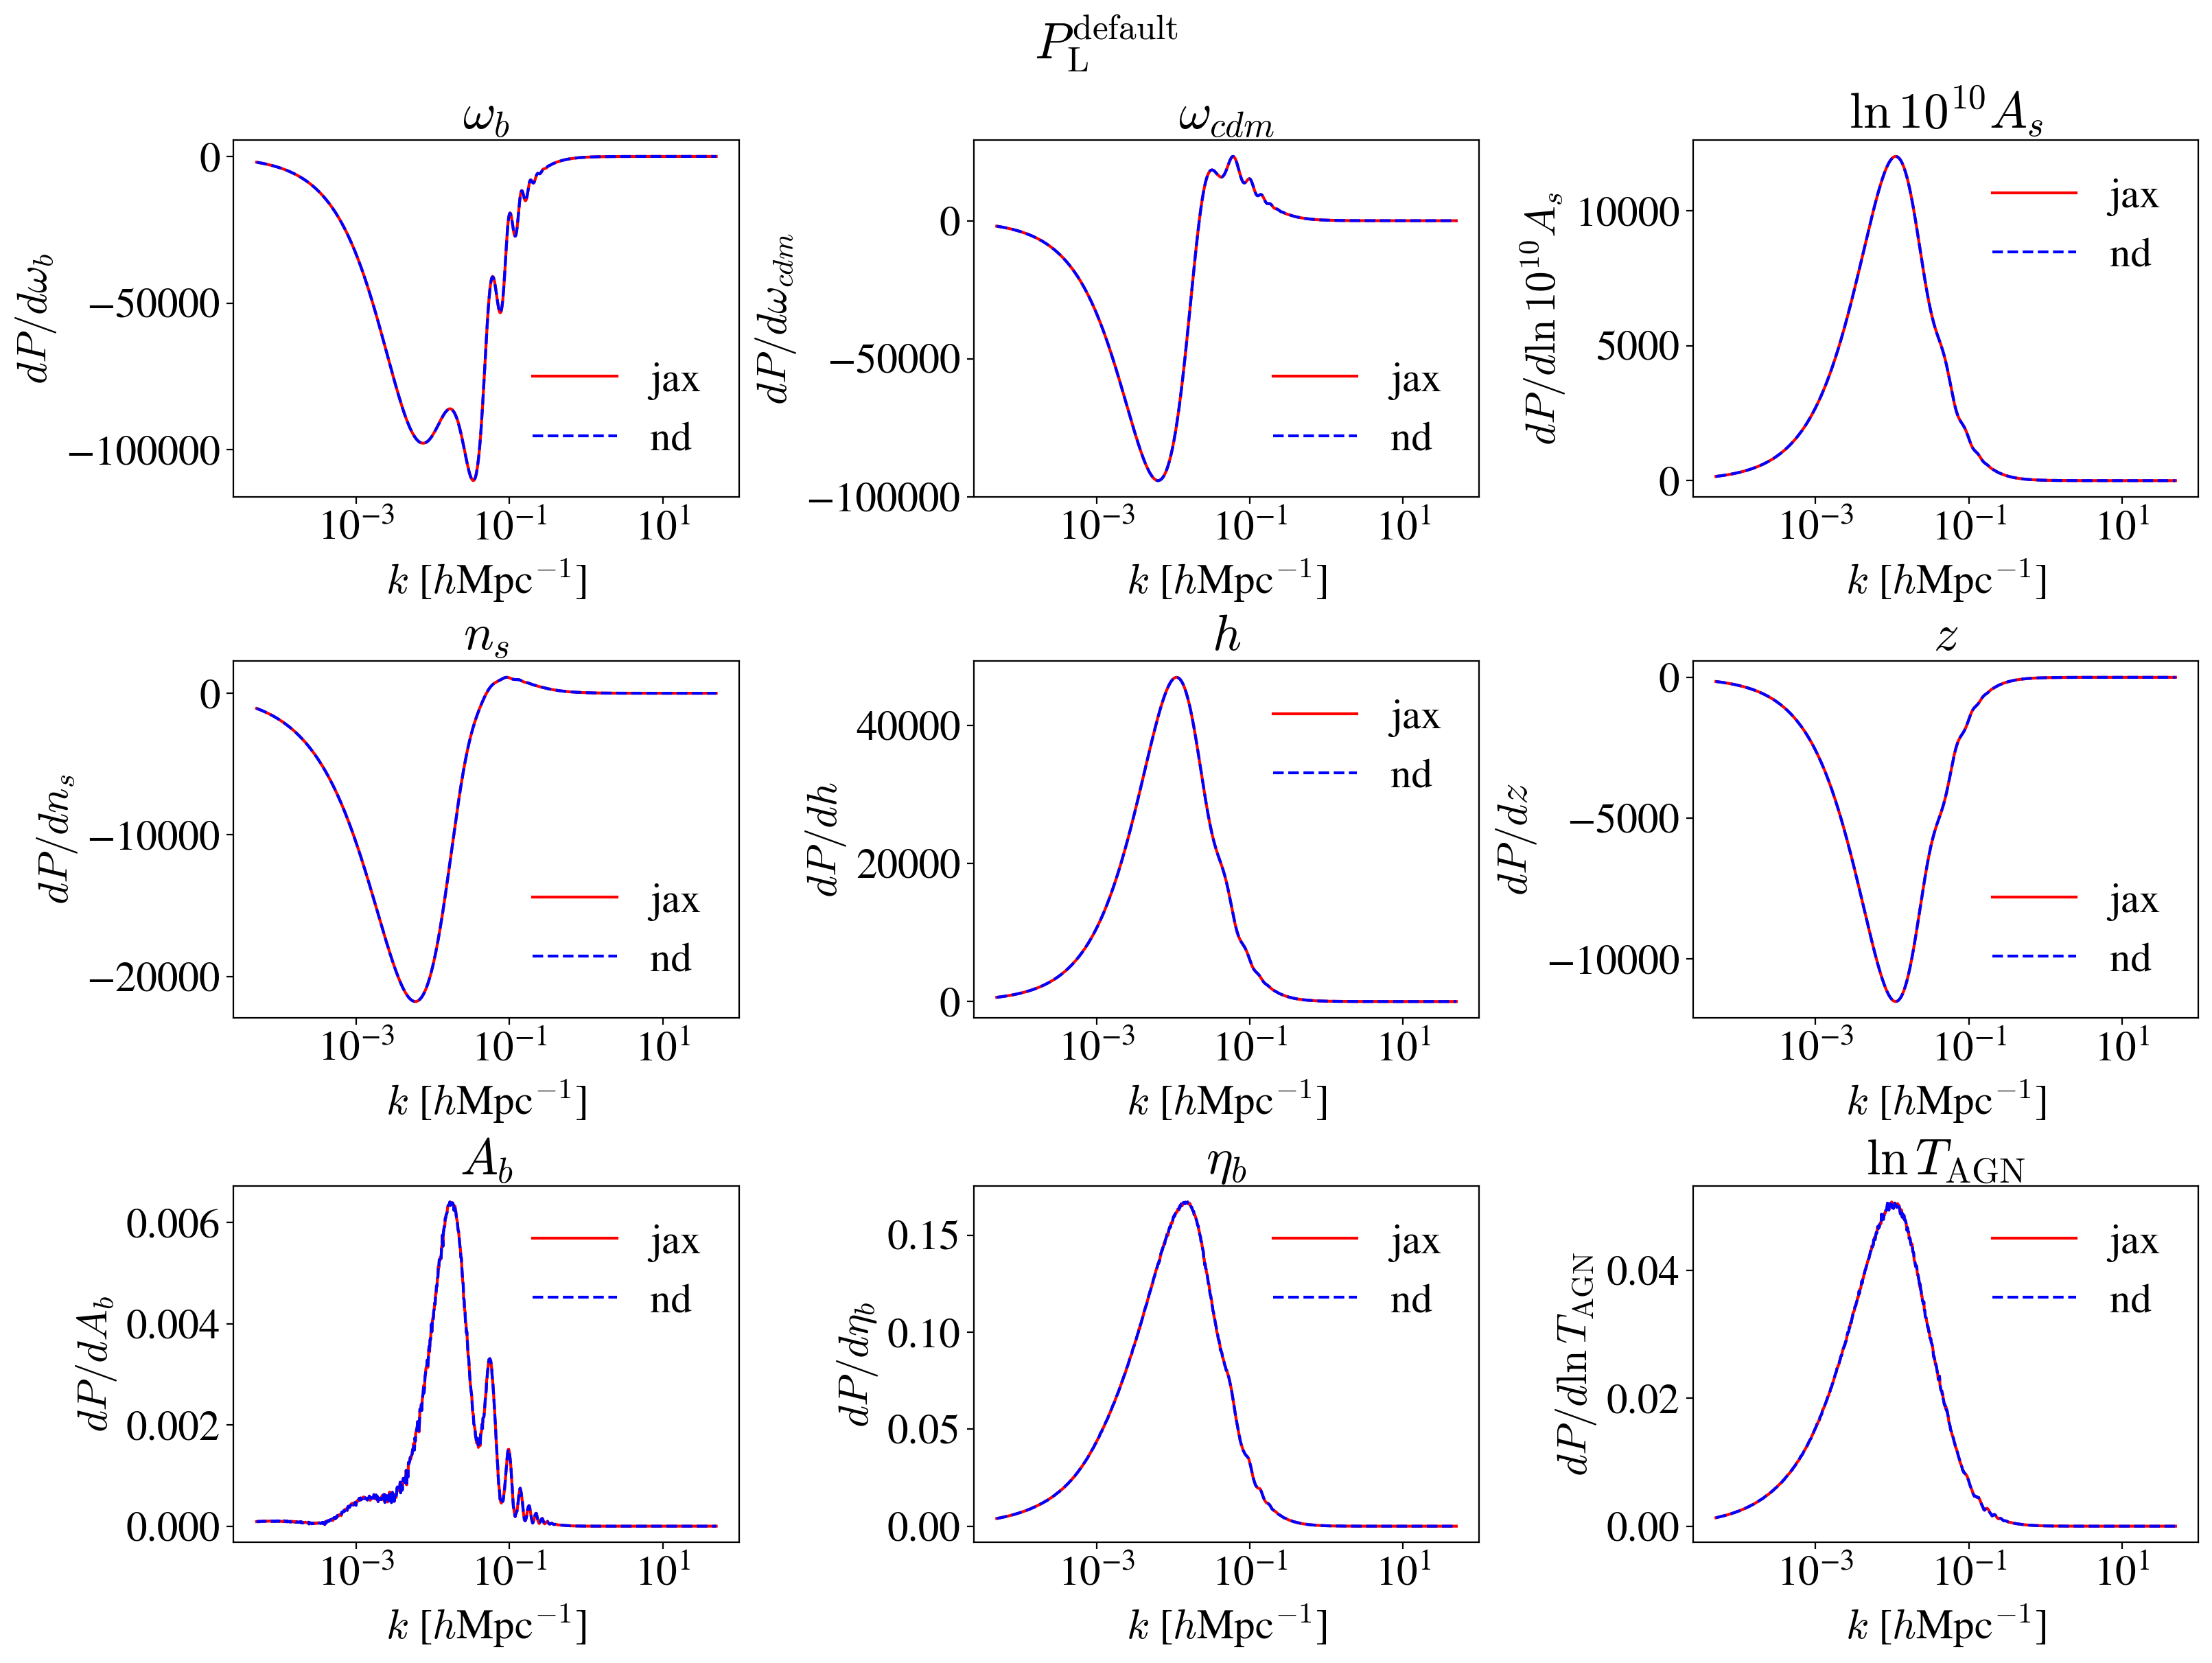

In [71]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16, 12),constrained_layout=True)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = axs[i, j]
        if idx >= len(custom_cosmo_labels):
            ax.axis('off')  # Hide unused subplot
            continue

        ax.semilogx(custom_k, custom_pklin_jac_jax[:, idx,0], c='r', label='jax')
        ax.semilogx(custom_k, custom_pklin_jac_num[:, idx], c='b', ls='--', label='nd')
        ax.set_title(custom_cosmo_labels[idx])
        ax.set_xlabel(r'$k$ [$h$Mpc$^{-1}$]')
        ax.set_ylabel(rf'$dP/d${custom_cosmo_labels[idx]}')
        ax.legend(frameon=False)
fig.suptitle(r"$P^{\mathrm{default}}_{\mathrm{L}}$")